## 1. Setup

In [1]:
# Install required libraries (run this once if needed)
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt


## 2. Dataset and Notation

- M: stellar mass (in units of solar mass, M⊙)
- T: effective stellar temperature (Kelvin, K)
- L: stellar luminosity (in units of solar luminosity, L⊙

M = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]

L = [0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0]

In [3]:
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

m = len(M)
l = len(L)

### 2.1 DataSet Visualization: Plot M vs L. 



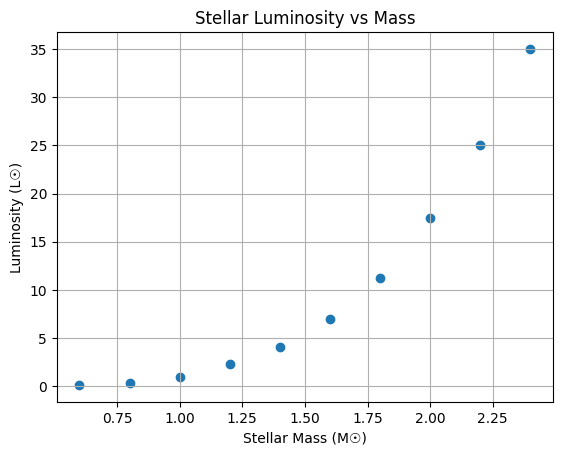

In [4]:
plt.figure()
plt.scatter(M, L)
plt.xlabel("Stellar Mass (M☉)")
plt.ylabel("Luminosity (L☉)")
plt.title("Stellar Luminosity vs Mass")
plt.grid(True)
plt.show()


The plot shows a strong positive correlation between stellar mass and luminosity, that is a good sign of some plausibility.

However, the relationship between both is clearly non linear: 
- luminosity increases slowly at low masses and much more rapidly at higher masses.


This suggests that a linear regression model will only provide a rough approximation and will underpredict luminosity for high-mass stars, as the relationship is not linear at higher masses.

## 3.Model and loss

The hypothesis models stellar luminosity as a linear function of mass with an explicit bias term.

The mean squared error is used as the loss function, measuring the average squared difference between predicted and observed luminosities.


Prediction

In [5]:
def predict(M, w, b):
    """Compute predictions f_{w,b}(x) for all examples.
    
    Linear regression model:
    L_hat = w * M + b
    
    """
    return M * w + b  # vectorized: matrix-vector product + scalar

w_test = 0.0
b_test = 0.0

l_hat_test = predict(M, w_test, b_test)
print("First 3 predictions with w = 0, b = 0:", l_hat_test[:3])

First 3 predictions with w = 0, b = 0: [0. 0. 0.]


MSE: mean squared error

In [6]:
## def compute_cost(x, y, w, b):
#    m = len(x)
#    y_hat = w * x + b
#    return np.sum((y_hat - y) ** 2) / (2 * m)

In [7]:
def mse(M, L, w, b):  #compute_cost
    """
    Mean Squared Error cost function
    """
    m = len(M)
    L_hat = predict(M, w, b)
    return (1 / (2 * m)) * np.sum((L_hat - L) ** 2) 

print("Cost with w = 0, b = 0: ", mse(M, L, w_test, b_test))

Cost with w = 0, b = 0:  117.69675000000001


## 4. Cost surface

Visualizing the cost surface before applying methods like gradient descent helps us understand the behavior of the model.
It allows us to see that there is a single global minimum, which is important to ensure that gradient descent will converge correctly.

Additionally, it helps us understand the sensitivity of the parameters: how small changes in w or b affect the cost.

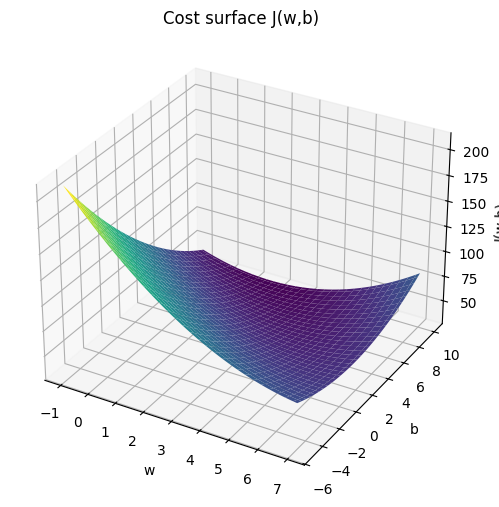

In [8]:
from mpl_toolkits.mplot3d import Axes3D  # needed to register the 3D projection
from matplotlib import cm
 
# Choose reasonable ranges around the expected optimum
w_vals = [float(v) for v in np.linspace(-1.0, 7.0, 60)]
b_vals = [float(v) for v in np.linspace(-5.0, 10.0, 60)]
 
J = np.zeros((len(w_vals), len(b_vals)))
 
for i, w in enumerate(w_vals):
    for j, b in enumerate(b_vals):
        J[i, j] = mse(M, L, w, b)
W, B = np.meshgrid(w_vals, b_vals)
 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(W, B, J, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_xlabel("w")
ax.set_ylabel("b")
ax.set_zlabel("J(w,b)")
ax.set_title("Cost surface J(w,b)")
plt.show()

The 3D plot shows how the MSE varies with slope (w) and bias (b).
The lowest point on the surface represents the optimal parameters that best fit the data.
Its convex shape confirms that the cost function has a single global minimum, which is why gradient descent can reliably find the optimal w and b.

## 5. Gradients

$$
\frac{\partial J}{\partial w} = \frac{1}{m} \sum_{i=1}^{m} \big( f_{w,b}(x^{(i)}) - y^{(i)} \big) x^{(i)}
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} \big( f_{w,b}(x^{(i)}) - y^{(i)} \big)
$$


$$
w := w - \alpha \frac{\partial J}{\partial w}, \qquad
b := b - \alpha \frac{\partial J}{\partial b}
$$

### 5.1 Gradient descent (non-vectorized)

In this implementation, gradients are computed using explicit loops over the dataset.
This approach closely follows the mathematical definition of gradient descent and is useful for understanding how parameter updates are performed step by step, although it is computationally inefficient for large datasets.

In [9]:

def compute_gradients(M, L, w, b):
    m = len(M)
    sum_dw = 0.0
    sum_db = 0.0


    for i in range (m):
        error = (w * M[i] + b) - L[i]

        sum_dw += error * M[i]
        sum_db += error

    sum_dw /= m
    sum_db /= m
    return sum_dw, sum_db

dw_test, db_test = compute_gradients(M, L, w_test, b_test)
print("dw =", dw_test, "db =", db_test) 


dw = -21.523000000000003 db = -10.36


### 5.2 Gradient descent (vectorized)

This implementation computes gradients using NumPy vectorized operations instead of explicit loops.
While mathematically equivalent to the non-vectorized version, this approach is significantly more efficient and scales better to large datasets.

In [10]:
def compute_gradients_vectorized(M, L, w, b):
    m = len(M)
    error = (w * M + b) - L

    dj_dw = (1 / m) * np.sum(error * M) 
    dj_db = (1 / m) * np.sum(error)
    return dj_dw, dj_db

dj_dw_test, dj_db_test = compute_gradients(M, L, w_test, b_test)
print("Gradients at w=0, b=0:", dj_dw_test, dj_db_test)

Gradients at w=0, b=0: -21.523000000000003 -10.36


### 5.3 Gradient descent (vectorized)


In this implementation, the gradients are computed using NumPy vectorized operations without explicit loops over the dataset.
This approach is mathematically equivalent to the non-vectorized version but is significantly more efficient and scalable.


$$
w := w - \alpha \frac{\partial J}{\partial w}, \qquad
b := b - \alpha \frac{\partial J}{\partial b}
$$

In [11]:
def gradient_descent_vectorized(M, L, alpha, num_iters):
    w = 0.0
    b = 0.0

    for _ in range(num_iters):
        dw, db = compute_gradients_vectorized(M, L, w, b)
        w -= alpha * dw
        b -= alpha * db

    return w, b


### 5.4 Implement the Gradient Descent Loop

In [ ]:

def gradient_descent(M, L, w_init, b_init, alpha, num_iterations):
    w = w_init
    b = b_init
    history = []
    
    for i in range(num_iterations):
        dj_dw, dj_db = compute_gradients_vectorized(M, L, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        cost = mse(M, L, w, b)
        history.append((i, cost))

        if i % max(1, (num_iterations // 10)) == 0:
            print(f"Iteration {i:4d}: w={w:7.4f}, b={b:7.4f}, cost={cost:8.4f}")

    return w, b, history



alpha = 0.01
num_iterations = 2000

w_init = 0.0
b_init = 0.0

w_learned, b_learned, history = gradient_descent(M, L, w_init, b_init, alpha, num_iterations)
print("Learned parameters:")
print("w =", w_learned)
print("b =", b_learned)


Iteration    0: w= 0.2152, b= 0.1036, cost=112.0896
Iteration  200: w= 7.9674, b=-0.0073, cost= 28.0913
Iteration  400: w= 9.7253, b=-2.9093, cost= 22.3208
Iteration  600: w=11.1759, b=-5.3129, cost= 18.3703
Iteration  800: w=12.3762, b=-7.3015, cost= 15.6658
Iteration 1000: w=13.3693, b=-8.9470, cost= 13.8142
Iteration 1200: w=14.1910, b=-10.3085, cost= 12.5466
Iteration 1400: w=14.8709, b=-11.4350, cost= 11.6788
Iteration 1600: w=15.4334, b=-12.3670, cost= 11.0847
Iteration 1800: w=15.8989, b=-13.1383, cost= 10.6780

Learned parameters:
w = 16.2822484076734
b = -13.77345340049044


## 6. Convergence (mandatory) Plot the Cost over Iterations

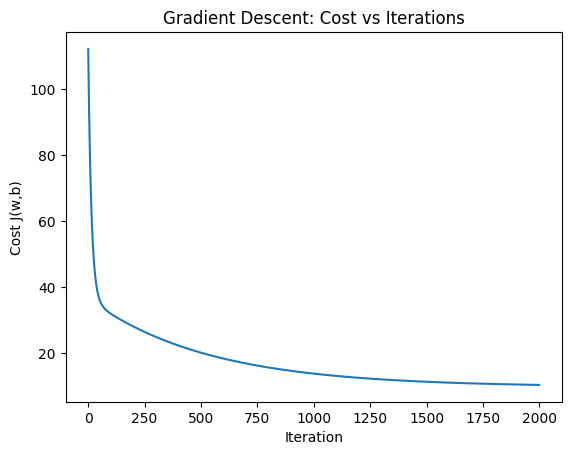

In [15]:
iterations = [it for it, c in history]
costs = [c for it, c in history]

plt.figure()
plt.plot(iterations, costs)
plt.xlabel("Iteration")
plt.ylabel("Cost J(w,b)")
plt.title("Gradient Descent: Cost vs Iterations")
plt.show()

The cost decreases monotonically as the number of iterations increases, indicating successful convergence.
With the chosen learning rate, the optimization is stable and does not show oscillations or divergence.
Most of the reduction in cost occurs during the first iterations, after which the improvement becomes gradual.

## 7. Experiments 

In [ ]:
alphas = [0.001, 0.01, 0.5]
num_iters = 1000

w_learned, b_learned, history = gradient_descent(M, L, w_init, b_init, alphas[0], num_iterations)
loss = mse(M, L, w_learned, b_learned)
print("Learned parameters with Alpha:", alphas[0])
print("w =", w_learned)
print("b =", b_learned) 
print("Loss =", loss)

w_learned, b_learned, history = gradient_descent(M, L, w_init, b_init, alphas[1], num_iterations)
print("Learned parameters with Alpha:", alphas[1])
loss = mse(M, L, w_learned, b_learned)
print("w =", w_learned)
print("b =", b_learned) 
print("Loss =", loss)

w_learned, b_learned, history = gradient_descent(M, L, w_init, b_init, alphas[2], num_iterations)
print("Learned parameters with Alpha:", alphas[2])
loss = mse(M, L, w_learned, b_learned)
print("w =", w_learned)
print("b =", b_learned) 
print("Loss =", loss)

Iteration    0: w= 0.0215, b= 0.0104, cost=117.1272
Iteration  200: w= 3.1775, b= 1.3941, cost= 55.5054
Iteration  400: w= 4.8589, b= 1.8976, cost= 39.5456
Iteration  600: w= 5.8048, b= 1.9668, cost= 34.9110
Iteration  800: w= 6.3826, b= 1.8233, cost= 33.1044
Iteration 1000: w= 6.7755, b= 1.5774, cost= 32.0220
Iteration 1200: w= 7.0742, b= 1.2837, cost= 31.1424
Iteration 1400: w= 7.3243, b= 0.9696, cost= 30.3358
Iteration 1600: w= 7.5483, b= 0.6484, cost= 29.5691
Iteration 1800: w= 7.7573, b= 0.3268, cost= 28.8333
Learned parameters with Alpha: 0.001
w = 7.95618583813993
b = 0.009567454004411478
Loss = 28.129021900815786
Iteration    0: w= 0.2152, b= 0.1036, cost=112.0896
Iteration  200: w= 7.9674, b=-0.0073, cost= 28.0913
Iteration  400: w= 9.7253, b=-2.9093, cost= 22.3208
Iteration  600: w=11.1759, b=-5.3129, cost= 18.3703
Iteration  800: w=12.3762, b=-7.3015, cost= 15.6658
Iteration 1000: w=13.3693, b=-8.9470, cost= 13.8142
Iteration 1200: w=14.1910, b=-10.3085, cost= 12.5466
Iterat

This demonstrates the importance of choosing an appropriate learning rate: if it is too small, training is slow; if it is too large, the model may not converge. A moderate learning rate provides a good balance between convergence speed and stability.

## 8. Final fit plot

In [24]:
alpha = 0.01
num_iterations = 2000

w_init = 0.0
b_init = 0.0

w_learned, b_learned, history = gradient_descent(M, L, w_init, b_init, alpha, num_iterations)
print("Learned parameters:")
print("w =", w_learned)
print("b =", b_learned)

Iteration    0: w= 0.2152, b= 0.1036, cost=112.0896
Iteration  200: w= 7.9674, b=-0.0073, cost= 28.0913
Iteration  400: w= 9.7253, b=-2.9093, cost= 22.3208
Iteration  600: w=11.1759, b=-5.3129, cost= 18.3703
Iteration  800: w=12.3762, b=-7.3015, cost= 15.6658
Iteration 1000: w=13.3693, b=-8.9470, cost= 13.8142
Iteration 1200: w=14.1910, b=-10.3085, cost= 12.5466
Iteration 1400: w=14.8709, b=-11.4350, cost= 11.6788
Iteration 1600: w=15.4334, b=-12.3670, cost= 11.0847
Iteration 1800: w=15.8989, b=-13.1383, cost= 10.6780
Learned parameters:
w = 16.2822484076734
b = -13.77345340049044


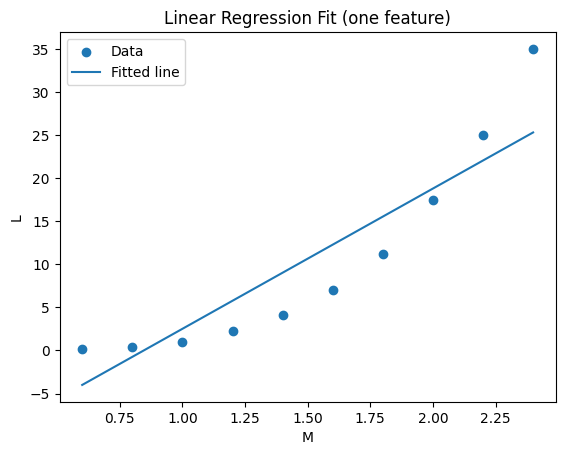

In [ ]:
plt.figure()
plt.scatter(M, L, label="Actual Data")
L_pred = predict(M, w_learned, b_learned)
plt.plot(M, L_pred, label="Fitted line")
plt.xlabel("M")
plt.ylabel("L")
plt.title("Linear Regression Fit (one feature)")
plt.legend()
plt.show()

We observed that the model captures the general trend of increasing luminosity with mass, but it underestimates the highest values ​​(more massive stars) and slightly overestimates the lowest values.

This highlights a limitation of the linear model: the relationship between mass and luminosity is not strictly linear, especially for more massive stars where luminosity increases nonlinearly.
A polynomial model could better capture this curvature.

## 9. Conceptual questions

1. Astrophyisical meaning of w: The parameter w indicates how the luminosity of a star changes when its mass increases.

In astrophysical terms, a positive w means that greater mass means greater luminosity; however, because the actual relationship is non-linear, w only represents an approximate linear average and does not fully capture the rapid luminosity growth for more massive stars.

2. Why is a linear model limited here? 
To improve the prediction, a polynomial or nonlinear model that captures this relationship would be required.

The actual relationship between the mass and luminosity of stars is not linear: 
- luminosity increases faster than mass. 

Therefore, a linear model can only approximate the general trend and tends to underestimate the most luminous stars and overestimate the least luminous.

This is clearly seen in the final fitted graph, where the straight line does not follow the actual curvature of the data.